# ANN Somatotopic Decoding Analysis

**Dataset:**
- **Participant:** sub-p0001
- **Runs:** 4
- **Total samples:** 160
- **Electrodes:** 20 (E1-E20)
- **Samples per electrode:** 8


In [1]:
import json 
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.image import load_img, index_img, resample_to_img, new_img_like
from nilearn import plotting
from nilearn.maskers import NiftiMasker
from nilearn.datasets import fetch_atlas_harvard_oxford
from sklearn.preprocessing import StandardScaler


RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
BIDS_ROOT = Path(r"C:/Users/duart/Desktop/Tese/Mapping_Tese/mapping_tese/data/BIDS-somatosensory/BIDS-somatosensory")
DERIVATIVES = BIDS_ROOT / "derivatives" / "fmriprep"

subjects = ["sub-p0001"]
session = "ses-01"
task = "task-S1Map"
space = "MNI152NLin2009cAsym"
n_runs_per_subject = 4


HRF_DELAY = 5.0
WINDOW = 1

bold_json = BIDS_ROOT / subjects[0] / session / "func" / f"{subjects[0]}_{session}_{task}_run-1_bold.json"
with open(bold_json, 'r', encoding='utf-8') as f:
    tr = float(json.load(f)["RepetitionTime"])
print(f"Subject: {subjects[0]}")
print(f"Runs: {n_runs_per_subject}")
print(f"TR: {tr} s")
print(f"HRF delay: {HRF_DELAY} s")
print(f"Window: {WINDOW} volumes")

RESULTS_DIR = Path("results/ANN")
FIGURES_DIR = RESULTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_LOG = RESULTS_DIR / "ANN_analysis_log.txt"
log_file = open(OUTPUT_LOG, 'w', encoding='utf-8')

Subject: sub-p0001
Runs: 4
TR: 2.0 s
HRF delay: 5.0 s
Window: 1 volumes


In [3]:
all_events = []
subject = subjects[0]
for run in range(1, n_runs_per_subject + 1):
    events_path = BIDS_ROOT / subject / session / "func" / f"{subject}_{session}_{task}_run-{run}_events.tsv"
    df = pd.read_csv(events_path, sep='\t')
    df['subject'] = subject
    df['run'] = run
    all_events.append(df)

events_df = pd.concat(all_events, ignore_index=True)
stim_events = events_df[~events_df['trial_type'].isin(['Baseline', 'Jitter'])].copy()

print(f"Subject: {subject}")
print(f"Total events: {len(events_df)}")
print(f"Stimulation events: {len(stim_events)}")
print(f"Unique electrodes: {stim_events['trial_type'].nunique()}")
print(f"\nSamples per run:")
print(stim_events.groupby('run').size().to_dict())
print(f"\nSamples per electrode:")
electrode_counts = stim_events['trial_type'].value_counts().sort_index()
print(f"  Min: {electrode_counts.min()}, Max: {electrode_counts.max()}, Mean: {electrode_counts.mean():.1f}")


first_run_path = (DERIVATIVES / subjects[0] / session / "func" /
                  f"{subjects[0]}_{session}_{task}_run-1_space-{space}_desc-preproc_bold.nii.gz")
first_run_img = load_img(str(first_run_path))
ref_img = index_img(first_run_img, 0)
print(f"Reference image shape: {first_run_img.shape}")

atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
s1_indices = [i for i, lab in enumerate(atlas.labels) if 'Postcentral Gyrus' in str(lab) and i != 0]
if len(s1_indices) == 0 and 'Postcentral Gyrus' in atlas.labels:
    s1_indices = [atlas.labels.index('Postcentral Gyrus')]

atlas_img = atlas.maps
atlas_data = atlas_img.get_fdata()
mask_data = np.isin(atlas_data, s1_indices).astype('uint8')
s1_mask = new_img_like(atlas_img, mask_data)
s1_mask_resampled = resample_to_img(s1_mask, ref_img, interpolation='nearest', force_resample=True, copy_header=True)
masker = NiftiMasker(mask_img=s1_mask_resampled, standardize=False)
masker.fit(first_run_img)

print(f"\nS1 atlas indices: {s1_indices}")
print('Selected atlas regions:')
for i in s1_indices:
    print(f"  - {atlas.labels[i]}")
print(f"Number of voxels in original S1 mask: {int(np.sum(mask_data))}")


display = plotting.plot_roi(s1_mask_resampled, bg_img=ref_img, 
                            title='S1 ROI Mask (Postcentral Gyrus)',
                            display_mode='ortho', cut_coords=(0, -20, 60))
display.savefig(FIGURES_DIR / 's1_mask.png', dpi=150)
display.close()
print(f"\nS1 mask saved to: {FIGURES_DIR / 's1_mask.png'}")

Subject: sub-p0001
Total events: 328
Stimulation events: 160
Unique electrodes: 20

Samples per run:
{1: 40, 2: 40, 3: 40, 4: 40}

Samples per electrode:
  Min: 8, Max: 8, Mean: 8.0
Reference image shape: (121, 144, 121, 250)
[fetch_atlas_harvard_oxford] Dataset found in C:\Users\duart\nilearn_data\fsl


C:\Users\duart\AppData\Local\Temp\ipykernel_11424\2571336030.py:41: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  masker.fit(first_run_img)



S1 atlas indices: [17]
Selected atlas regions:
  - Postcentral Gyrus
Number of voxels in original S1 mask: 6895

S1 mask saved to: results\ANN\figures\s1_mask.png


### BOLD volumes for each stimulation event

In [4]:
X_list = []
y_list = []
run_labels = []

for run in range(1, n_runs_per_subject + 1):
    bold_path = (DERIVATIVES / subjects[0] / session / "func" /
                  f"{subjects[0]}_{session}_{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz")
    bold_img = load_img(str(bold_path))
    print(f"Run {run}...")
    run_events = stim_events[stim_events['run'] == run]
    for indx,(_, event) in enumerate(run_events.iterrows()):
        onset = event["onset"]
        trial_type = event["trial_type"]
        target_time = onset + HRF_DELAY
        vol_indx = int(np.round(target_time / tr))
        
        if vol_indx < bold_img.shape[3]:
            vol_img = index_img(bold_img, vol_indx)
            vol_data = masker.transform(vol_img)
            if len(vol_data.shape) == 2:
                X_list.append(vol_data[0])
            else:
                X_list.append(vol_data)
            y_list.append(trial_type)
            run_labels.append(run)

X = np.array(X_list)
y = np.array(y_list)
run_labels = np.array(run_labels)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of unique electrodes: {len(np.unique(y))}")

Run 1...
Run 2...
Run 3...
Run 4...

Feature matrix shape: (160, 13434)
Labels shape: (160,)
Number of unique electrodes: 20


In [5]:
unique_labels = sorted(np.unique(y))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
y_encoded = np.array([label_to_idx[label] for label in y])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")
print(f"  Min: {X_scaled.min():.2f}")
print(f"  Max: {X_scaled.max():.2f}")

  Mean: 0.000000
  Std: 0.794549
  Min: -9.06
  Max: 12.61


In [6]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
X_scaled_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"Reduced features: {X_scaled_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

X_scaled = X_scaled_pca

Original features: 13434
Reduced features: 100
Explained variance: 86.51%


In [7]:
test_run = 4
train_mask = run_labels != test_run
test_mask = run_labels == test_run

X_train = X_scaled[train_mask]
X_test = X_scaled[test_mask]
y_train = y_encoded[train_mask]
y_test = y_encoded[test_mask]

print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test samples: {X_test.shape[0]} ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\nTraining set class distribution:")
train_counts = pd.Series(y_train).value_counts().sort_index()
print(f"  Samples per class: min={train_counts.min()}, max={train_counts.max()}, mean={train_counts.mean():.1f}")
print(f"\nTest set class distribution:")
test_counts = pd.Series(y_test).value_counts().sort_index()
print(f"  Samples per class: min={test_counts.min()}, max={test_counts.max()}, mean={test_counts.mean():.1f}")

Training samples: 120 (75.0%)
Test samples: 40 (25.0%)

Training set class distribution:
  Samples per class: min=6, max=6, mean=6.0

Test set class distribution:
  Samples per class: min=2, max=2, mean=2.0


### Pytorch tensors

***batch_size = 16***

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Module, Linear, ReLU, Sequential, Dropout

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Input features (voxels): {X_train.shape[1]}")
print(f"Output classes: {len(unique_labels)}")

Batch size: 16
Number of training batches: 8
Input features (voxels): 100
Output classes: 20


### ANN Model

***Linear***

***ReLU***

In [13]:
class SomatotopicANN(Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes, dropout_rate):
        super(SomatotopicANN, self).__init__()
        self.network = Sequential(
            Linear(input_size, hidden1),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden1, hidden2),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.network(x)
    

### Training parameters

***learning rate = 0.0001***

***epochs = 150***

***CrossEntropyLoss***

***optimizer = Adam***

***L2 Weight decay = 0.01***

***hidden1 = 128, hidden2 = 64***

***dropout_rate = 0.5***

In [14]:
print("Starting Training...\n")
log_file.write("=== Training Log ===\n\n")

learning_rate = 0.0001
num_epochs = 300
weight_decay = 0.01
criterion = CrossEntropyLoss()

print(f"Hyperparameters:")
print(f"  Learning rate: {learning_rate}")
print(f"  Number of epochs: {num_epochs}")
print(f"  Optimizer: Adam")
print(f"  Loss function: CrossEntropyLoss")
print(f"Weight Decay = {weight_decay}")

log_file.write(f"Hyperparameters:\n")
log_file.write(f"  Learning rate: {learning_rate}\n")
log_file.write(f"  Epochs: {num_epochs}\n")
log_file.write(f"  Optimizer: Adam")
log_file.write(f"  Loss function: CrossEntropyLoss")
log_file.write(f"  Batch size: {batch_size}\n\n")
log_file.write(f"Weight Decay = {weight_decay}")
log_file.flush()

input_size = X_train.shape[1]
hidden1 = 128
hidden2 = 64
num_classes = len(unique_labels)
dropout_rate = 0.5

model = SomatotopicANN(input_size, hidden1, hidden2, num_classes, dropout_rate)
torch.manual_seed(RANDOM_SEED)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_losses = []
train_accuracies = []
test_accuracies = []

print(f"Architecture: {model}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
log_file.write(f"=== ANN TRAINING ===\n")
log_file.write(f"Model Architecture:\n{model}\n\n")
log_file.write(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}\n")
log_file.write(f"Training samples: {X_train.shape[0]}\n")
log_file.write(f"Test samples: {X_test.shape[0]}\n")
log_file.write(f"Input features: {input_size}\n")
log_file.write(f"Output classes: {num_classes}\n\n")
log_file.flush()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_acc = (correct / total) * 100
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data,1)
        test_acc = ((test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)) * 100
        test_accuracies.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        message = f"Epoch [{epoch+1:3d}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:6.2f}% | Test Acc: {test_acc:6.2f}%"
        print(message)
        log_file.write(message + '\n')
        log_file.flush()

print("\nTraining complete!")
log_file.write("\n=== TRAINING COMPLETE ===\n\n")
log_file.flush()

Starting Training...

Hyperparameters:
  Learning rate: 0.0001
  Number of epochs: 300
  Optimizer: Adam
  Loss function: CrossEntropyLoss
Weight Decay = 0.01
Architecture: SomatotopicANN(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=20, bias=True)
  )
)

Total parameters: 22,484
Epoch [ 10/300] | Loss: 3.6945 | Train Acc:   9.17% | Test Acc:   0.00%
Epoch [ 20/300] | Loss: 3.3332 | Train Acc:  10.00% | Test Acc:   0.00%
Epoch [ 30/300] | Loss: 3.3058 | Train Acc:   7.50% | Test Acc:   2.50%
Epoch [ 40/300] | Loss: 3.0971 | Train Acc:  15.83% | Test Acc:   2.50%
Epoch [ 50/300] | Loss: 3.0623 | Train Acc:  15.00% | Test Acc:   2.50%
Epoch [ 60/300] | Loss: 2.9650 | Train Acc:  12.50% | Test Acc:   0.00%
Epoch [ 70/300] | Loss: 2.590

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model.eval()
with torch.no_grad():
    final_outputs = model(X_test_tensor)
    _, final_predictions = torch.max(final_outputs.data, 1)

y_pred = final_predictions.tolist()
test_accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
electrode_names = [idx_to_label[i] for i in range(num_classes)]
report = classification_report(y_test, y_pred, target_names=electrode_names, zero_division=0)

print(f"\n{'='*70}")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"{'='*70}")
print("\nClassification Report:")
print(report)

log_file.write(f"{'='*70}\n")
log_file.write(f"FINAL TEST ACCURACY: {test_accuracy*100:.2f}%\n")
log_file.write(f"{'='*70}\n\n")
log_file.write("Classification Report:\n")
log_file.write(report + "\n")
log_file.flush()


Final Test Accuracy: 5.00%

Classification Report:
              precision    recall  f1-score   support

          E1       0.00      0.00      0.00         2
         E10       0.00      0.00      0.00         2
         E11       0.00      0.00      0.00         2
         E12       0.00      0.00      0.00         2
         E13       0.00      0.00      0.00         2
         E14       0.00      0.00      0.00         2
         E15       0.00      0.00      0.00         2
         E16       0.00      0.00      0.00         2
         E17       0.00      0.00      0.00         2
         E18       0.00      0.00      0.00         2
         E19       0.25      0.50      0.33         2
          E2       0.00      0.00      0.00         2
         E20       0.00      0.00      0.00         2
          E3       0.00      0.00      0.00         2
          E4       0.00      0.00      0.00         2
          E5       0.00      0.00      0.00         2
          E6       0.09      

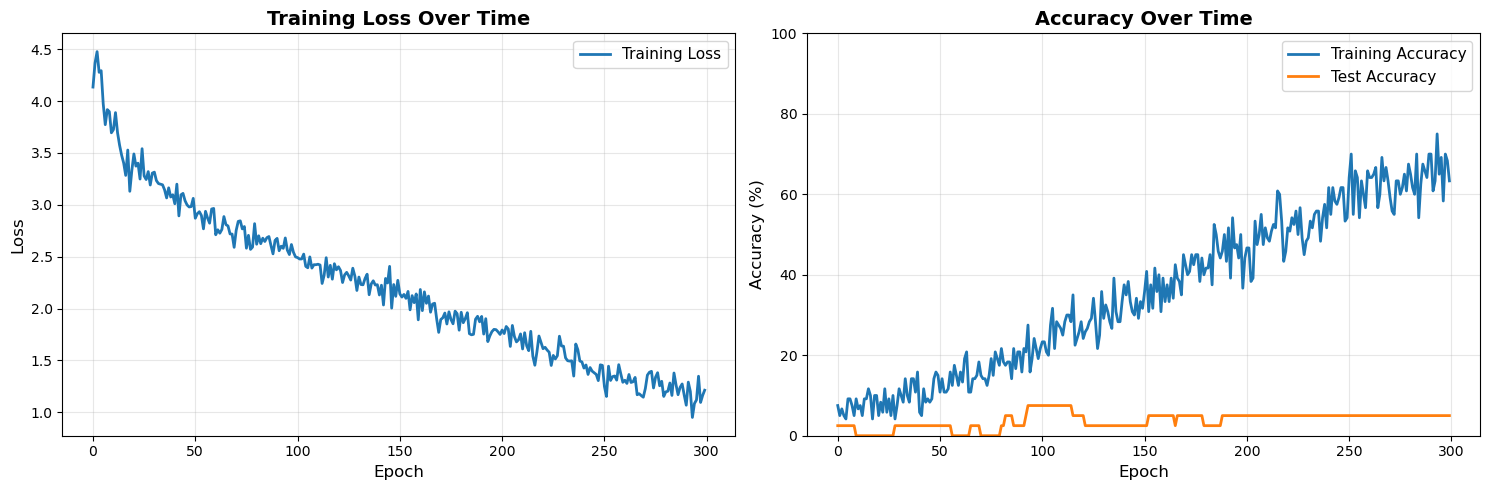

Training curves saved to: results\ANN\figures\training_curves.png


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Training Loss', linewidth=2, color='#1f77b4')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Training Accuracy', linewidth=2, color='#1f77b4')
axes[1].plot(test_accuracies, label='Test Accuracy', linewidth=2, color='#ff7f0e')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 100])

plt.tight_layout()
plt.savefig(FIGURES_DIR / "training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved to: {FIGURES_DIR / 'training_curves.png'}")

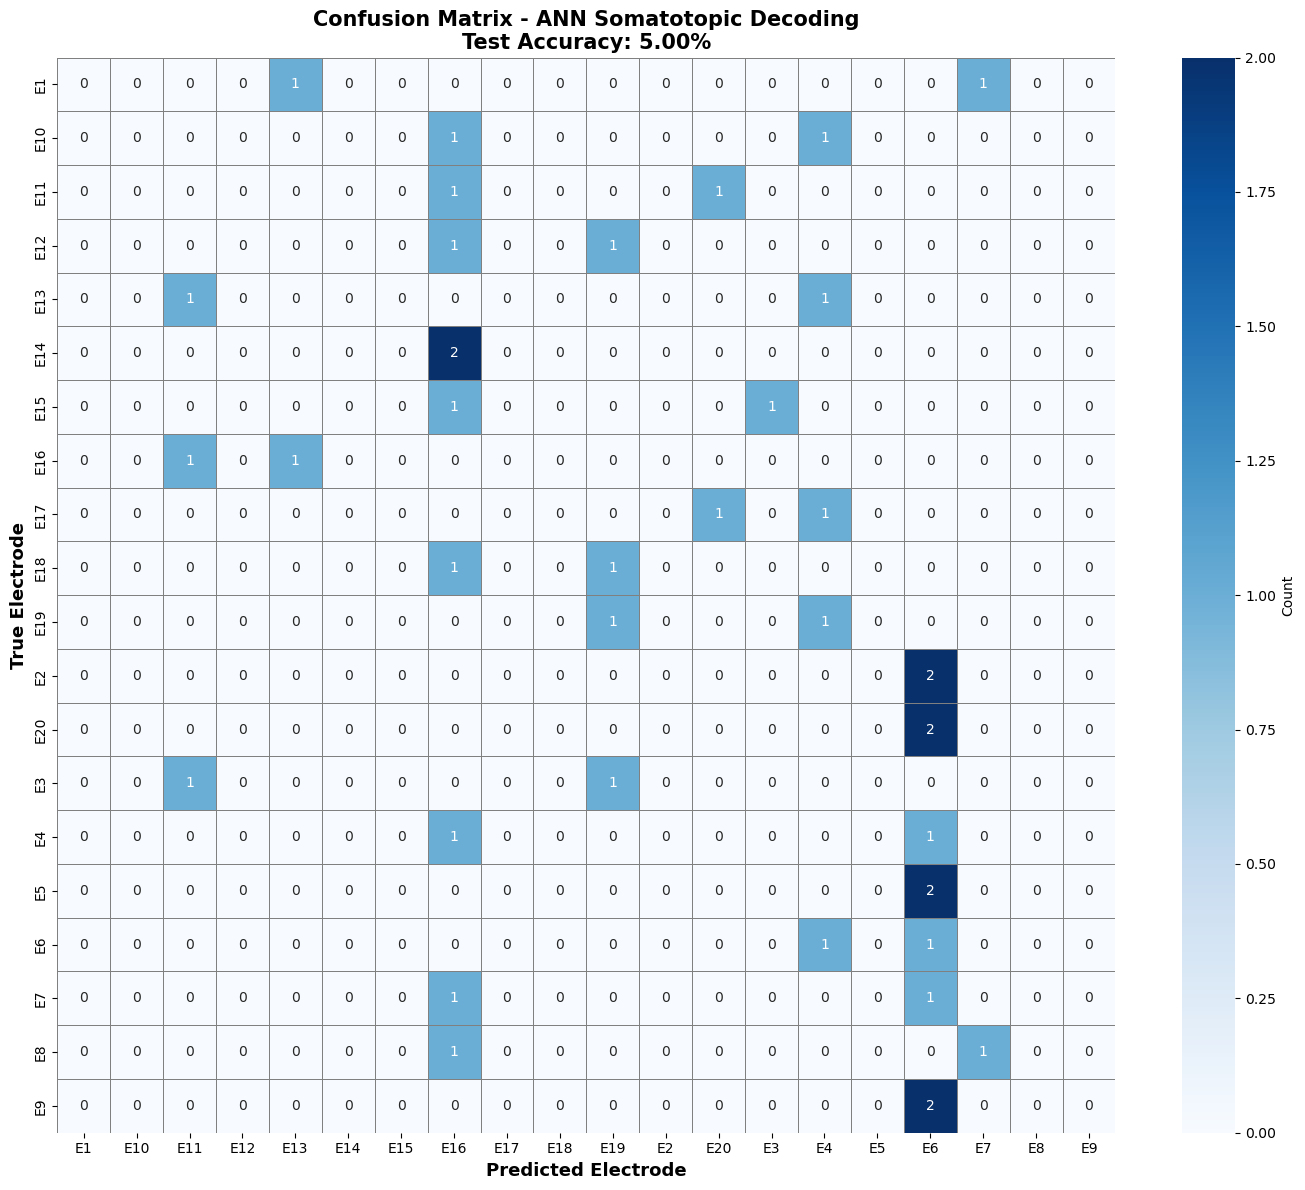

Confusion matrix saved to: results\ANN\figures\confusion_matrix.png


In [22]:
import seaborn as sns

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=electrode_names, yticklabels=electrode_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Electrode', fontsize=13, fontweight='bold')
plt.ylabel('True Electrode', fontsize=13, fontweight='bold')
plt.title(f'Confusion Matrix - ANN Somatotopic Decoding\nTest Accuracy: {test_accuracy*100:.2f}%', 
          fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to: {FIGURES_DIR / 'confusion_matrix.png'}")

In [23]:
log_file.close()
print(f"\n{'='*70}")
print(f"Analysis complete! All results saved to: {RESULTS_DIR}")
print(f"{'='*70}")
print(f"\nOutput files:")
print(f"  - Log: {OUTPUT_LOG}")
print(f"  - Training curves: {FIGURES_DIR / 'training_curves.png'}")
print(f"  - Confusion matrix: {FIGURES_DIR / 'confusion_matrix.png'}")
print(f"  - S1 mask: {FIGURES_DIR / 's1_mask.png'}")


Analysis complete! All results saved to: results\ANN

Output files:
  - Log: results\ANN\ANN_analysis_log.txt
  - Training curves: results\ANN\figures\training_curves.png
  - Confusion matrix: results\ANN\figures\confusion_matrix.png
  - S1 mask: results\ANN\figures\s1_mask.png
